# Visual NLP ChartToTextTable

In [1]:
import pkg_resources

from pyspark.ml import PipelineModel
import pyspark.sql.functions as f
from pyspark.sql.functions import explode

from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

from sparkocr.transformers import ChartToTextTable

/tmp/ipykernel_68545/484983167.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
# Start spark
spark = start(jar_path="../../target/scala-2.12")

Spark version: 3.4.1
Spark NLP version: 5.2.3
Spark NLP for Healthcare version: 5.1.1
Spark OCR version: 5.2.0rc2



### Define pipeline

In [3]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

chart_to_text = ChartToTextTable()\
    .pretrained("chart_to_text_deplot_jsl", "en", "clinical/ocr")\
    .setInputCol(["image"])\
    .setOutputCol("answers")\
    .setUseCaching(False)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    chart_to_text
])

chart_to_text_deplot_jsl download started this may take some time.
Approximate size to download 999.7 MB


### Load test images

In [4]:
test_image_path = './data/charts/*'

In [5]:
# import pkg_resources
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/home/jose/s...|2024-02-16 18:05:...| 22080|[89 50 4E 47 0D 0...|
|file:/home/jose/s...|2024-02-16 18:05:...| 16697|[89 50 4E 47 0D 0...|
+--------------------+--------------------+------+--------------------+




    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/charts/chart2.png
    Resolution: 0 dpi
    Width: 600 px
    Height: 680 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


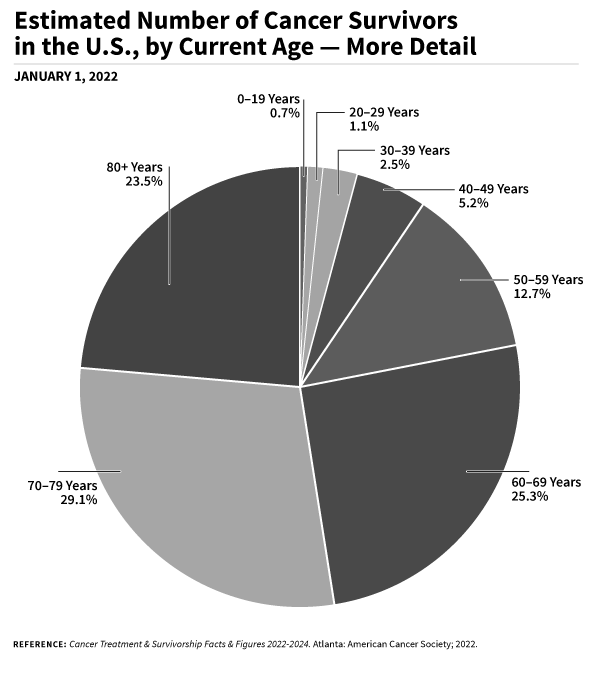


    Image #1:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/charts/chart1.png
    Resolution: 0 dpi
    Width: 1000 px
    Height: 685 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


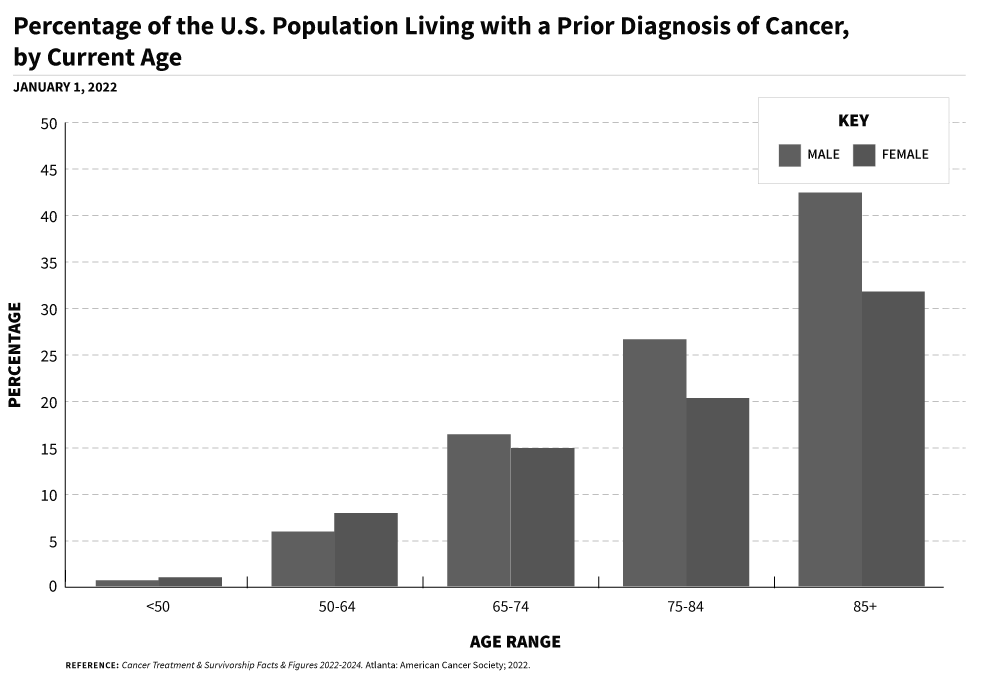

In [6]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)

## Call pipeline

In [9]:
results = pipeline.transform(bin_df).cache()

In [10]:
results.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- exception: string (nullable = true)
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- pagenum: integer (nullable = true)
 |-- answers: struct (nullable = true)
 |    |-- questions: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- answers: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- scores: array (nullable = true)
 |    |    |-- element: float (containsNull = false)



In [17]:
results.select(results.answers.answers).show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|answers.answers                                                                                                                                                                                                                                                                                                                                     |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------